In [291]:
%matplotlib inline
import numpy as np
np.random.seed(123)

import random as rn
rn.seed(231)

import tensorflow as tf
tf.random.set_seed(321)

import pandas as pd
from tensorflow.keras import layers
import seaborn as sns
import epitopepredict as ep
from keras import *
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import os
import platform
print("Python Version: ", platform.python_version())
print(os.getcwd())

Python Version:  3.7.4
/Users/matthewbuckley/Dropbox/TCR.Learning/notebooks


In [57]:
# Load data
data = pd.read_csv('../R/data/PairedTCR_HLA-A*02.01_VDJdb.tsv', delimiter="\t" )
print(data.shape)

(3555, 11)


In [58]:
data.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,mhc.a,mhc.b,reference.id,antigen.epitope
0,CAGNNARPMF,TRAV27*01,TRAJ31*01,CASSQSPGGVAFF,TRBV14*01,NaN,TRBJ1-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML
1,CAGNNARLMF,TRAV27*01,TRAJ31*01,CASSQSPGGVAFF,TRBV14*01,NaN,TRBJ1-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML
2,CAGNNARLVF,TRAV27*01,TRAJ31*01,CASSQSPGGTQYF,TRBV14*01,NaN,TRBJ2-5*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML
3,CAEGFASSDGQKLLF,TRAV5*01,NaN,CASSQSPGGTQYF,TRBV14*01,NaN,TRBJ2-5*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML
4,CAGNNARLMF,TRAV27*01,TRAJ31*01,CSARDRHREWLHF,TRBV20-1*01,NaN,TRBJ1-2*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML


In [59]:
data['antigen.epitope'].value_counts()

GILGFVFTL     2044
ELAGIGILTV     329
GLCTLVAML      302
LLWNGPMAV      247
NLVPMVATV      198
CINGVCWTV       79
RTLNAWVKV       47
FLYALALLL       38
SLFNTVATLY      38
LLFGYPVYV       34
FLASKIGRLV      34
LLDFVRFMGV      26
KLSALGINAV      22
KTWGQYWQV       16
CVNGSCFTV       14
MLDLQPETT       14
YLLEMLWRL       13
IMDQVPFSV       12
KVLEYVIKV        8
YLNDHLEPWI       7
CLLWSFQTSA       7
RMFPNAPYL        7
SLLMWITQV        6
SLFNTVATL        5
CLLGTYTQDV       3
SLYNTVATLY       2
ILKEPVHGV        1
KLQCVDLHV        1
KVAELVHFL        1
Name: antigen.epitope, dtype: int64

In [60]:
data = data.groupby("antigen.epitope").filter(lambda x: len(x) > 50)
print(data["antigen.epitope"].value_counts())

GILGFVFTL     2044
ELAGIGILTV     329
GLCTLVAML      302
LLWNGPMAV      247
NLVPMVATV      198
CINGVCWTV       79
Name: antigen.epitope, dtype: int64


In [61]:
data = data.drop_duplicates('cdr3.beta', inplace=False)
print(data.shape)

(1871, 11)


In [180]:
# Naive Accuracy
max(data["antigen.epitope"].value_counts()) / sum(data["antigen.epitope"].value_counts())

0.498663816141101

In [63]:
# Largest cdr3.beta sequence?
sizes = [len(i) for i in data["cdr3.beta"]]
max(sizes)

21

In [64]:
# Padding
data["cdr3.beta.pad"] = data["cdr3.beta"].str.ljust(22, "0")
data.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,mhc.a,mhc.b,reference.id,antigen.epitope,cdr3.beta.pad
0,CAGNNARPMF,TRAV27*01,TRAJ31*01,CASSQSPGGVAFF,TRBV14*01,NaN,TRBJ1-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSQSPGGVAFF000000000
2,CAGNNARLVF,TRAV27*01,TRAJ31*01,CASSQSPGGTQYF,TRBV14*01,NaN,TRBJ2-5*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSQSPGGTQYF000000000
4,CAGNNARLMF,TRAV27*01,TRAJ31*01,CSARDRHREWLHF,TRBV20-1*01,NaN,TRBJ1-2*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CSARDRHREWLHF000000000
6,CVVNGASGTYKYIF,TRAV12-1*01,TRAJ40*01,CASSEDAGLSYNEQFF,TRBV6-1*01,NaN,TRBJ2-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSEDAGLSYNEQFF000000
8,CAEGQTDKLIF,TRAV5*01,TRAJ34*01,CASSVGNEQFF,TRBV9*01,NaN,TRBJ2-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSVGNEQFF00000000000


In [194]:
train, val = train_test_split(data, test_size=0.2)
#train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1496 train examples
375 validation examples
375 test examples


### One Hot

In [292]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '0']

def show_matrix(m):
    #display a matrix
    cm = sns.light_palette("seagreen", as_cmap=True)
    display(m.style.background_gradient(cmap=cm))

def one_hot_encode(seq):
    o = list(set(codes) - set(seq)) # list on the aa codes not present in seq
    s = pd.DataFrame(list(seq)) # create a dataframe out of aa's in seq
    x = pd.DataFrame(np.zeros((len(seq),len(o)),dtype=int),columns=o) # All 0 encoding for aa not in seq    
    a = s[0].str.get_dummies(sep=',') # Actually encodes s
    a = a.join(x) # combine encoded seq with extra aa's
    a = a.sort_index(axis=1) # Sort columns by aa code
    show_matrix(a) # Heatmap
    e = a.values.flatten() # flatten into a len(seq) * len(codes) length vector
    return e

pep='AYLDFEQEMT000'
e=one_hot_encode(pep)

,0,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Blosum62

In [196]:
blosum = pd.DataFrame(ep.blosum62)
print(blosum.shape)
print(blosum.head())

(24, 24)
   A  R  N  D  C  Q  E  G  H  I  ...  P  S  T  W  Y  V  B  Z  X  *
A  4 -1 -2 -2  0 -1 -1  0 -2 -1  ... -1  1  0 -3 -2  0 -2 -1  0 -4
R -1  5  0 -2 -3  1  0 -2  0 -3  ... -2 -1 -1 -3 -2 -3 -1  0 -1 -4
N -2  0  6  1 -3  0  0  0  1 -3  ... -2  1  0 -4 -2 -3  3  0 -1 -4
D -2 -2  1  6 -3  0  2 -1 -1 -3  ... -1  0 -1 -4 -3 -3  4  1 -1 -4
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1  ... -3 -1 -1 -2 -2 -1 -3 -3 -2 -4

[5 rows x 24 columns]


In [197]:
blosum.rename(columns = {"*" : "0"}, index =  {"*" : "0"}, inplace=True)

In [198]:
def blosum_encode(seq, show=True):
    #encode a peptide into blosum features
    s = list(seq)
    x = pd.DataFrame([blosum[i] for i in seq]).reset_index(drop=True)
    if show:
        show_matrix(x)
    e = x.values.flatten()    
    return e

def random_encode(p):
    return [np.random.randint(20) for i in pep]

e=blosum_encode(pep)

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V,B,Z,X,0
0,4,-1,-2,-2,0,-1,-1,0,-2,-1,-1,-1,-1,-2,-1,1,0,-3,-2,0,-2,-1,0,-4
1,-2,-2,-2,-3,-2,-1,-2,-3,2,-1,-1,-2,-1,3,-3,-2,-2,2,7,-1,-3,-2,-1,-4
2,-1,-2,-3,-4,-1,-2,-3,-4,-3,2,4,-2,2,0,-3,-2,-1,-2,-1,1,-4,-3,-1,-4
3,-2,-2,1,6,-3,0,2,-1,-1,-3,-4,-1,-3,-3,-1,0,-1,-4,-3,-3,4,1,-1,-4
4,-2,-3,-3,-3,-2,-3,-3,-3,-1,0,0,-3,0,6,-4,-2,-2,1,3,-1,-3,-3,-1,-4
5,-1,0,0,2,-4,2,5,-2,0,-3,-3,1,-2,-3,-1,0,-1,-3,-2,-2,1,4,-1,-4
6,-1,1,0,0,-3,5,2,-2,0,-3,-2,1,0,-3,-1,0,-1,-2,-1,-2,0,3,-1,-4
7,-1,0,0,2,-4,2,5,-2,0,-3,-3,1,-2,-3,-1,0,-1,-3,-2,-2,1,4,-1,-4
8,-1,-1,-2,-3,-1,0,-2,-3,-2,1,2,-1,5,0,-2,-1,-1,-1,-1,1,-3,-1,-1,-4
9,0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,1,5,-2,-2,0,-1,-1,0,-4


## Convert labels

In [199]:
train["antigen.epitope"].shape

(1496,)

In [200]:
len(train["antigen.epitope"].unique())

6

In [201]:
OneHotEncoder(sparse=False).fit_transform(train["antigen.epitope"].values.reshape(-1,1)).shape

(1496, 6)

In [209]:
train_encode.shape

(1496, 528)

## Model on Encoded CDR3 Data

In [202]:
train_encode = np.array([blosum_encode(seq=x, show=False) for x in train["cdr3.beta.pad"]])

label_encoder = OneHotEncoder(sparse=False).fit(train["antigen.epitope"].values.reshape(-1,1))
train_encode_labels = label_encoder.transform(train["antigen.epitope"].values.reshape(-1,1))

print(train_encode.shape)
print(train_encode_labels.shape)

(1496, 528)
(1496, 6)


In [274]:
# Encode validation or dev set
dev_encode = np.array([blosum_encode(seq =x, show=False) for x in val["cdr3.beta.pad"]])
dev_encode_labels = label_encoder.transform(val["antigen.epitope"].values.reshape(-1,1))

In [309]:
# For a single-input model with 10 classes (categorical classification):
from keras.layers import *

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=528))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())
# Train the model, iterating on the data in batches of 32 samples
np.random.seed(0)
history = model.fit(train_encode, train_encode_labels, validation_data=(dev_encode, dev_encode_labels), epochs=200, batch_size=128, shuffle=False)

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 32)                16928     
_________________________________________________________________
dense_75 (Dense)             (None, 12)                396       
_________________________________________________________________
dense_76 (Dense)             (None, 6)                 78        
Total params: 17,402
Trainable params: 17,402
Non-trainable params: 0
_________________________________________________________________
None
Train on 1496 samples, validate on 375 samples
Epoch 1/200
1496/1496 [==============================] - 1s 352us/step - loss: 2.3154 - accuracy: 0.2279 - val_loss: 1.8254 - val_accuracy: 0.2427
Epoch 2/200
1496/1496 [==============================] - 0s 19us/step - loss: 1.5400 - accuracy: 0.4078 - val_loss: 1.5833 - val_accuracy: 0.4720
Epoch 3/200
1496/1496 [===========

1496/1496 [==============================] - 0s 22us/step - loss: 0.7617 - accuracy: 0.7313 - val_loss: 1.4594 - val_accuracy: 0.5307
Epoch 52/200
1496/1496 [==============================] - 0s 22us/step - loss: 0.7556 - accuracy: 0.7259 - val_loss: 1.4616 - val_accuracy: 0.5173
Epoch 53/200
1496/1496 [==============================] - 0s 22us/step - loss: 0.7449 - accuracy: 0.7293 - val_loss: 1.4697 - val_accuracy: 0.5093
Epoch 54/200
1496/1496 [==============================] - 0s 23us/step - loss: 0.7327 - accuracy: 0.7373 - val_loss: 1.4917 - val_accuracy: 0.5200
Epoch 55/200
1496/1496 [==============================] - 0s 20us/step - loss: 0.7261 - accuracy: 0.7340 - val_loss: 1.5207 - val_accuracy: 0.5200
Epoch 56/200
1496/1496 [==============================] - 0s 21us/step - loss: 0.7272 - accuracy: 0.7366 - val_loss: 1.5223 - val_accuracy: 0.5253
Epoch 57/200
1496/1496 [==============================] - 0s 22us/step - loss: 0.7352 - accuracy: 0.7246 - val_loss: 1.5498 - val_a

Epoch 107/200
1496/1496 [==============================] - 0s 22us/step - loss: 0.4402 - accuracy: 0.8516 - val_loss: 1.8334 - val_accuracy: 0.4880
Epoch 108/200
1496/1496 [==============================] - 0s 22us/step - loss: 0.4282 - accuracy: 0.8616 - val_loss: 1.8440 - val_accuracy: 0.4880
Epoch 109/200
1496/1496 [==============================] - 0s 20us/step - loss: 0.4220 - accuracy: 0.8723 - val_loss: 1.8719 - val_accuracy: 0.4853
Epoch 110/200
1496/1496 [==============================] - 0s 21us/step - loss: 0.4178 - accuracy: 0.8710 - val_loss: 1.9204 - val_accuracy: 0.4960
Epoch 111/200
1496/1496 [==============================] - 0s 20us/step - loss: 0.4115 - accuracy: 0.8710 - val_loss: 1.9516 - val_accuracy: 0.5013
Epoch 112/200
1496/1496 [==============================] - 0s 21us/step - loss: 0.4012 - accuracy: 0.8810 - val_loss: 1.9545 - val_accuracy: 0.5067
Epoch 113/200
1496/1496 [==============================] - 0s 20us/step - loss: 0.3971 - accuracy: 0.8803 - val_

1496/1496 [==============================] - 0s 22us/step - loss: 0.2861 - accuracy: 0.9171 - val_loss: 2.7889 - val_accuracy: 0.5147
Epoch 163/200
1496/1496 [==============================] - 0s 25us/step - loss: 0.2978 - accuracy: 0.9078 - val_loss: 2.8895 - val_accuracy: 0.5120
Epoch 164/200
1496/1496 [==============================] - 0s 30us/step - loss: 0.2955 - accuracy: 0.9124 - val_loss: 2.9170 - val_accuracy: 0.4907
Epoch 165/200
1496/1496 [==============================] - 0s 23us/step - loss: 0.3025 - accuracy: 0.9031 - val_loss: 2.8777 - val_accuracy: 0.4773
Epoch 166/200
1496/1496 [==============================] - 0s 21us/step - loss: 0.3206 - accuracy: 0.8877 - val_loss: 2.9141 - val_accuracy: 0.4960
Epoch 167/200
1496/1496 [==============================] - 0s 21us/step - loss: 0.3274 - accuracy: 0.8884 - val_loss: 2.9746 - val_accuracy: 0.4800
Epoch 168/200
1496/1496 [==============================] - 0s 20us/step - loss: 0.3545 - accuracy: 0.8770 - val_loss: 3.0336 -

In [307]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


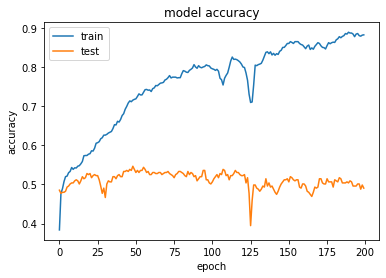

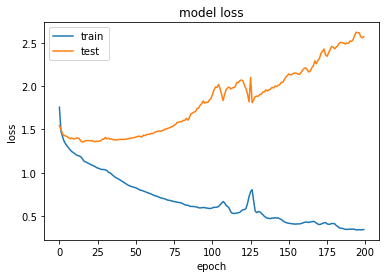

In [308]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### This looks like an overfitting/variance issue. Dev set accuracy plateaus at 25 epochs of training. 

In [279]:
train_labels = np.argmax(train_encode_labels, axis=1)
train_predictions = model.predict_classes(train_encode)
print(train_labels.shape)
print(train_predictions.shape)

(1496,)
(1496,)


In [280]:
print(confusion_matrix(train_labels, train_predictions))

[[ 37   7   8   2   0   2]
 [  0 232   7   5   5   4]
 [  1  16 689   4  30   9]
 [  2  11   5 109   1   0]
 [  0   7  14   2 164   3]
 [  0   4  15   2   3  96]]


In [293]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py: 

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=5)

Confusion matrix, without normalization
[[ 37   7   8   2   0   2]
 [  0 232   7   5   5   4]
 [  1  16 689   4  30   9]
 [  2  11   5 109   1   0]
 [  0   7  14   2 164   3]
 [  0   4  15   2   3  96]]
Normalized confusion matrix
[[0.66071 0.125   0.14286 0.03571 0.      0.03571]
 [0.      0.917   0.02767 0.01976 0.01976 0.01581]
 [0.00134 0.02136 0.91989 0.00534 0.04005 0.01202]
 [0.01562 0.08594 0.03906 0.85156 0.00781 0.     ]
 [0.      0.03684 0.07368 0.01053 0.86316 0.01579]
 [0.      0.03333 0.125   0.01667 0.025   0.8    ]]


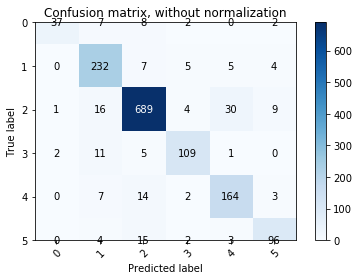

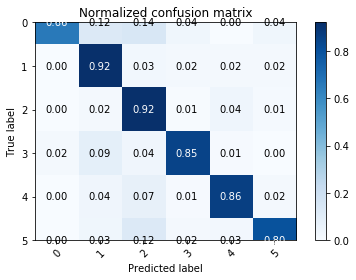

In [298]:
plot_confusion_matrix(train_labels, train_predictions,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(train_labels, train_predictions, normalize=True,
                      title='Normalized confusion matrix')


Confusion matrix, without normalization
[[  2   1   9   2   0   3]
 [  3  28  14   3  14   7]
 [  5  23 111  15  12  18]
 [  1   6  10   7   6   5]
 [  2   3   7   3  20   3]
 [  1   6  16   0   1   8]]
Normalized confusion matrix
[[0.11765 0.05882 0.52941 0.11765 0.      0.17647]
 [0.04348 0.4058  0.2029  0.04348 0.2029  0.10145]
 [0.02717 0.125   0.60326 0.08152 0.06522 0.09783]
 [0.02857 0.17143 0.28571 0.2     0.17143 0.14286]
 [0.05263 0.07895 0.18421 0.07895 0.52632 0.07895]
 [0.03125 0.1875  0.5     0.      0.03125 0.25   ]]


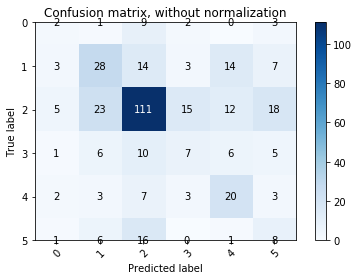

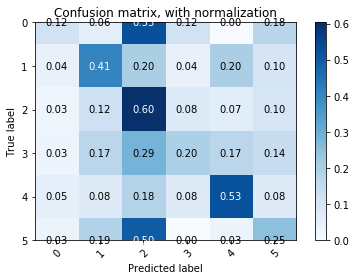

In [300]:
dev_labels = np.argmax(dev_encode_labels, axis=1)
dev_predictions = model.predict_classes(dev_encode)
plot_confusion_matrix(dev_labels, dev_predictions, normalize=False,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(dev_labels, dev_predictions, normalize=True,
                      title='Confusion matrix, with normalization')


## Random Forest Baseline

In [303]:
clf = RandomForestClassifier(n_estimators=300)
clf.fit(train_encode, train['antigen.epitope'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [304]:
clf.score(dev_encode, val['antigen.epitope'].values)

0.6133333333333333

In [305]:
# Naive Accuracy
max(val["antigen.epitope"].value_counts()) / sum(val["antigen.epitope"].value_counts())

0.49066666666666664

# Reformat data for RNN

In [210]:
train_encode2 = train_encode.reshape((train_encode.shape[0], 22, -1))

In [212]:
dev_encode2 = dev_encode.reshape((dev_encode.shape[0], 22, -1))

In [211]:
train_encode2.shape

(1496, 22, 24)

## Try NN Model #2

In [228]:
model = Sequential()
model.add(LSTM(16, input_shape=(22,24)))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [236]:
# Train the model, iterating on the data in batches of 32 samples
np.random.seed(0)
history = model.fit(train_encode2, train_encode_labels, validation_data=(dev_encode2, dev_encode_labels), epochs=400, batch_size=64, shuffle=False)

Train on 1496 samples, validate on 375 samples
Epoch 1/400
1496/1496 [==============================] - 0s 334us/step - loss: 0.5580 - accuracy: 0.8162 - val_loss: 1.8487 - val_accuracy: 0.4907
Epoch 2/400
1496/1496 [==============================] - 0s 317us/step - loss: 0.7079 - accuracy: 0.7580 - val_loss: 1.8584 - val_accuracy: 0.4747
Epoch 3/400
1496/1496 [==============================] - 0s 310us/step - loss: 0.6828 - accuracy: 0.7667 - val_loss: 1.8830 - val_accuracy: 0.4533
Epoch 4/400
1496/1496 [==============================] - 0s 313us/step - loss: 0.6526 - accuracy: 0.7781 - val_loss: 1.8584 - val_accuracy: 0.4853
Epoch 5/400
1496/1496 [==============================] - 0s 309us/step - loss: 0.6342 - accuracy: 0.7901 - val_loss: 1.8491 - val_accuracy: 0.4613
Epoch 6/400
1496/1496 [==============================] - 0s 326us/step - loss: 0.6876 - accuracy: 0.7620 - val_loss: 1.8910 - val_accuracy: 0.4800
Epoch 7/400
1496/1496 [==============================] - 0s 319us/step 

1496/1496 [==============================] - 0s 319us/step - loss: 0.5398 - accuracy: 0.8162 - val_loss: 1.9219 - val_accuracy: 0.4720
Epoch 57/400
1496/1496 [==============================] - 0s 325us/step - loss: 0.5338 - accuracy: 0.8249 - val_loss: 1.9279 - val_accuracy: 0.4640
Epoch 58/400
1496/1496 [==============================] - 0s 306us/step - loss: 0.5600 - accuracy: 0.8108 - val_loss: 1.9142 - val_accuracy: 0.4560
Epoch 59/400
1496/1496 [==============================] - 0s 308us/step - loss: 0.5623 - accuracy: 0.8108 - val_loss: 1.9526 - val_accuracy: 0.4640
Epoch 60/400
1496/1496 [==============================] - 1s 359us/step - loss: 0.5720 - accuracy: 0.8055 - val_loss: 1.9194 - val_accuracy: 0.4533
Epoch 61/400
1496/1496 [==============================] - 0s 326us/step - loss: 0.5503 - accuracy: 0.8115 - val_loss: 1.8913 - val_accuracy: 0.4667
Epoch 62/400
1496/1496 [==============================] - 0s 316us/step - loss: 0.5310 - accuracy: 0.8202 - val_loss: 1.9698 

1496/1496 [==============================] - 0s 322us/step - loss: 0.5257 - accuracy: 0.8275 - val_loss: 1.9190 - val_accuracy: 0.4587
Epoch 112/400
1496/1496 [==============================] - 0s 315us/step - loss: 0.5195 - accuracy: 0.8289 - val_loss: 1.9558 - val_accuracy: 0.4480
Epoch 113/400
1496/1496 [==============================] - 0s 310us/step - loss: 0.5414 - accuracy: 0.8128 - val_loss: 1.8764 - val_accuracy: 0.4747
Epoch 114/400
1496/1496 [==============================] - 0s 304us/step - loss: 0.5379 - accuracy: 0.8222 - val_loss: 1.8776 - val_accuracy: 0.4747
Epoch 115/400
1496/1496 [==============================] - 0s 313us/step - loss: 0.5252 - accuracy: 0.8309 - val_loss: 1.9295 - val_accuracy: 0.4667
Epoch 116/400
1496/1496 [==============================] - 0s 325us/step - loss: 0.5294 - accuracy: 0.8282 - val_loss: 1.9664 - val_accuracy: 0.4400
Epoch 117/400
1496/1496 [==============================] - 0s 309us/step - loss: 0.5602 - accuracy: 0.8035 - val_loss: 1

1496/1496 [==============================] - 0s 312us/step - loss: 0.5165 - accuracy: 0.8316 - val_loss: 1.9951 - val_accuracy: 0.4773
Epoch 167/400
1496/1496 [==============================] - 0s 305us/step - loss: 0.5495 - accuracy: 0.8229 - val_loss: 1.8979 - val_accuracy: 0.5040
Epoch 168/400
1496/1496 [==============================] - 0s 307us/step - loss: 0.5420 - accuracy: 0.8142 - val_loss: 1.9803 - val_accuracy: 0.4720
Epoch 169/400
1496/1496 [==============================] - 0s 308us/step - loss: 0.5288 - accuracy: 0.8222 - val_loss: 2.0073 - val_accuracy: 0.4613
Epoch 170/400
1496/1496 [==============================] - 0s 310us/step - loss: 0.5156 - accuracy: 0.8262 - val_loss: 1.9642 - val_accuracy: 0.4853
Epoch 171/400
1496/1496 [==============================] - 0s 310us/step - loss: 0.5076 - accuracy: 0.8356 - val_loss: 2.0235 - val_accuracy: 0.4747
Epoch 172/400
1496/1496 [==============================] - 0s 314us/step - loss: 0.5055 - accuracy: 0.8356 - val_loss: 2

1496/1496 [==============================] - 0s 329us/step - loss: 0.4624 - accuracy: 0.8556 - val_loss: 2.0358 - val_accuracy: 0.4587
Epoch 222/400
1496/1496 [==============================] - 0s 311us/step - loss: 0.4604 - accuracy: 0.8556 - val_loss: 2.0466 - val_accuracy: 0.4640
Epoch 223/400
1496/1496 [==============================] - 0s 307us/step - loss: 0.4779 - accuracy: 0.8382 - val_loss: 2.0527 - val_accuracy: 0.4533
Epoch 224/400
1496/1496 [==============================] - 0s 317us/step - loss: 0.4812 - accuracy: 0.8449 - val_loss: 2.0275 - val_accuracy: 0.4587
Epoch 225/400
1496/1496 [==============================] - 0s 310us/step - loss: 0.4656 - accuracy: 0.8523 - val_loss: 2.0247 - val_accuracy: 0.4773
Epoch 226/400
1496/1496 [==============================] - 0s 308us/step - loss: 0.4959 - accuracy: 0.8396 - val_loss: 2.0425 - val_accuracy: 0.4613
Epoch 227/400
1496/1496 [==============================] - 0s 304us/step - loss: 0.4872 - accuracy: 0.8389 - val_loss: 1

1496/1496 [==============================] - 0s 306us/step - loss: 0.4612 - accuracy: 0.8476 - val_loss: 2.0211 - val_accuracy: 0.4693
Epoch 277/400
1496/1496 [==============================] - 0s 309us/step - loss: 0.4546 - accuracy: 0.8536 - val_loss: 2.0869 - val_accuracy: 0.4640
Epoch 278/400
1496/1496 [==============================] - 0s 314us/step - loss: 0.4571 - accuracy: 0.8549 - val_loss: 2.0524 - val_accuracy: 0.4720
Epoch 279/400
1496/1496 [==============================] - 0s 317us/step - loss: 0.4517 - accuracy: 0.8516 - val_loss: 2.0744 - val_accuracy: 0.4640
Epoch 280/400
1496/1496 [==============================] - 0s 316us/step - loss: 0.4691 - accuracy: 0.8449 - val_loss: 2.0737 - val_accuracy: 0.4720
Epoch 281/400
1496/1496 [==============================] - 0s 307us/step - loss: 0.5785 - accuracy: 0.8082 - val_loss: 2.0678 - val_accuracy: 0.4587
Epoch 282/400
1496/1496 [==============================] - 0s 307us/step - loss: 0.7816 - accuracy: 0.7426 - val_loss: 1

1496/1496 [==============================] - 0s 304us/step - loss: 0.7440 - accuracy: 0.7333 - val_loss: 1.8271 - val_accuracy: 0.4800
Epoch 332/400
1496/1496 [==============================] - 0s 309us/step - loss: 0.7151 - accuracy: 0.7507 - val_loss: 1.8502 - val_accuracy: 0.4933
Epoch 333/400
1496/1496 [==============================] - 0s 301us/step - loss: 0.6888 - accuracy: 0.7580 - val_loss: 1.8455 - val_accuracy: 0.4747
Epoch 334/400
1496/1496 [==============================] - 0s 308us/step - loss: 0.6618 - accuracy: 0.7741 - val_loss: 1.9029 - val_accuracy: 0.4720
Epoch 335/400
1496/1496 [==============================] - 0s 303us/step - loss: 0.6408 - accuracy: 0.7888 - val_loss: 1.9130 - val_accuracy: 0.4720
Epoch 336/400
1496/1496 [==============================] - 0s 308us/step - loss: 0.6292 - accuracy: 0.7814 - val_loss: 1.9315 - val_accuracy: 0.4720
Epoch 337/400
1496/1496 [==============================] - 0s 304us/step - loss: 0.6171 - accuracy: 0.7861 - val_loss: 1

1496/1496 [==============================] - 0s 312us/step - loss: 0.4685 - accuracy: 0.8436 - val_loss: 2.1071 - val_accuracy: 0.4693
Epoch 387/400
1496/1496 [==============================] - 0s 307us/step - loss: 0.4522 - accuracy: 0.8529 - val_loss: 2.1394 - val_accuracy: 0.4613
Epoch 388/400
1496/1496 [==============================] - 0s 303us/step - loss: 0.4441 - accuracy: 0.8583 - val_loss: 2.1173 - val_accuracy: 0.4720
Epoch 389/400
1496/1496 [==============================] - 0s 312us/step - loss: 0.4420 - accuracy: 0.8570 - val_loss: 2.0935 - val_accuracy: 0.4640
Epoch 390/400
1496/1496 [==============================] - 0s 319us/step - loss: 0.4343 - accuracy: 0.8570 - val_loss: 2.1218 - val_accuracy: 0.4800
Epoch 391/400
1496/1496 [==============================] - 1s 341us/step - loss: 0.4326 - accuracy: 0.8583 - val_loss: 2.0854 - val_accuracy: 0.4747
Epoch 392/400
1496/1496 [==============================] - 0s 324us/step - loss: 0.4232 - accuracy: 0.8616 - val_loss: 2

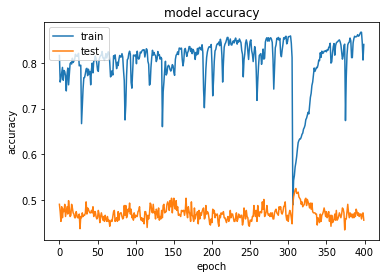

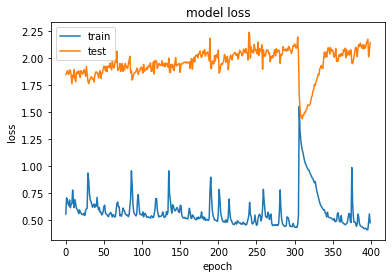

In [237]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### It appears we have a variance problem.

# 1D Convolutional

In [239]:
train_encode.shape

(1496, 528)

In [263]:
model_m = Sequential()
#model_m.add(Reshape((22, 24), input_shape=(22,24)))
model_m.add(Conv1D(10, 7, activation='relu', input_shape=(22,24)))
model_m.add(Conv1D(10, 3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(16, 3, activation='relu'))
model_m.add(Conv1D(16, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16, 10)            1690      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 14, 10)            310       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 7, 10)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5, 16)             496       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 3, 16)             784       
_________________________________________________________________
global_average_pooling1d_5 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)              

In [264]:
model_m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [266]:
history = model_m.fit(train_encode2, train_encode_labels, validation_data=(dev_encode2, dev_encode_labels), epochs=200, batch_size=64, shuffle=False)

Train on 1496 samples, validate on 375 samples
Epoch 1/200
1496/1496 [==============================] - 0s 106us/step - loss: 0.7986 - accuracy: 0.6992 - val_loss: 1.4688 - val_accuracy: 0.5360
Epoch 2/200
1496/1496 [==============================] - 0s 101us/step - loss: 0.7870 - accuracy: 0.6945 - val_loss: 1.4909 - val_accuracy: 0.5440
Epoch 3/200
1496/1496 [==============================] - 0s 100us/step - loss: 0.7936 - accuracy: 0.7032 - val_loss: 1.4762 - val_accuracy: 0.5627
Epoch 4/200
1496/1496 [==============================] - 0s 98us/step - loss: 0.7846 - accuracy: 0.7005 - val_loss: 1.5050 - val_accuracy: 0.5573
Epoch 5/200
1496/1496 [==============================] - 0s 104us/step - loss: 0.7520 - accuracy: 0.7159 - val_loss: 1.5391 - val_accuracy: 0.5547
Epoch 6/200
1496/1496 [==============================] - 0s 102us/step - loss: 0.7879 - accuracy: 0.6979 - val_loss: 1.5397 - val_accuracy: 0.5440
Epoch 7/200
1496/1496 [==============================] - 0s 102us/step -

1496/1496 [==============================] - 0s 101us/step - loss: 0.6253 - accuracy: 0.7553 - val_loss: 2.0553 - val_accuracy: 0.5360
Epoch 57/200
1496/1496 [==============================] - 0s 108us/step - loss: 0.6350 - accuracy: 0.7627 - val_loss: 2.1236 - val_accuracy: 0.5253
Epoch 58/200
1496/1496 [==============================] - 0s 104us/step - loss: 0.6105 - accuracy: 0.7527 - val_loss: 2.0548 - val_accuracy: 0.5307
Epoch 59/200
1496/1496 [==============================] - 0s 103us/step - loss: 0.6226 - accuracy: 0.7533 - val_loss: 2.0992 - val_accuracy: 0.5333
Epoch 60/200
1496/1496 [==============================] - 0s 104us/step - loss: 0.6186 - accuracy: 0.7527 - val_loss: 2.0173 - val_accuracy: 0.5307
Epoch 61/200
1496/1496 [==============================] - 0s 102us/step - loss: 0.6266 - accuracy: 0.7594 - val_loss: 2.1665 - val_accuracy: 0.5440
Epoch 62/200
1496/1496 [==============================] - 0s 103us/step - loss: 0.6388 - accuracy: 0.7440 - val_loss: 2.1059 

1496/1496 [==============================] - 0s 101us/step - loss: 0.5703 - accuracy: 0.7881 - val_loss: 2.9955 - val_accuracy: 0.5573
Epoch 112/200
1496/1496 [==============================] - 0s 98us/step - loss: 0.5553 - accuracy: 0.7881 - val_loss: 2.7088 - val_accuracy: 0.5413
Epoch 113/200
1496/1496 [==============================] - 0s 100us/step - loss: 0.5423 - accuracy: 0.7868 - val_loss: 2.9237 - val_accuracy: 0.5387
Epoch 114/200
1496/1496 [==============================] - 0s 100us/step - loss: 0.5585 - accuracy: 0.7807 - val_loss: 2.8546 - val_accuracy: 0.5333
Epoch 115/200
1496/1496 [==============================] - 0s 100us/step - loss: 0.5372 - accuracy: 0.7961 - val_loss: 2.7417 - val_accuracy: 0.5307
Epoch 116/200
1496/1496 [==============================] - 0s 102us/step - loss: 0.5633 - accuracy: 0.7834 - val_loss: 2.6627 - val_accuracy: 0.5227
Epoch 117/200
1496/1496 [==============================] - 0s 103us/step - loss: 0.5543 - accuracy: 0.7861 - val_loss: 2.

1496/1496 [==============================] - 0s 103us/step - loss: 0.5182 - accuracy: 0.7995 - val_loss: 3.6600 - val_accuracy: 0.5360
Epoch 167/200
1496/1496 [==============================] - 0s 105us/step - loss: 0.4960 - accuracy: 0.8028 - val_loss: 3.3577 - val_accuracy: 0.5253
Epoch 168/200
1496/1496 [==============================] - 0s 104us/step - loss: 0.4779 - accuracy: 0.8148 - val_loss: 3.5217 - val_accuracy: 0.5360
Epoch 169/200
1496/1496 [==============================] - 0s 102us/step - loss: 0.4817 - accuracy: 0.8108 - val_loss: 3.6669 - val_accuracy: 0.5387
Epoch 170/200
1496/1496 [==============================] - 0s 102us/step - loss: 0.4737 - accuracy: 0.8282 - val_loss: 3.4627 - val_accuracy: 0.5387
Epoch 171/200
1496/1496 [==============================] - 0s 101us/step - loss: 0.4855 - accuracy: 0.8102 - val_loss: 3.1888 - val_accuracy: 0.5253
Epoch 172/200
1496/1496 [==============================] - 0s 104us/step - loss: 0.4796 - accuracy: 0.8115 - val_loss: 3

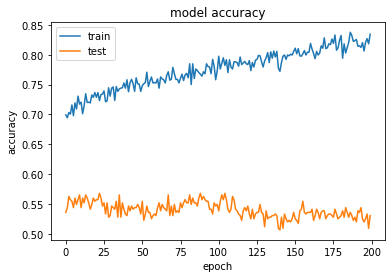

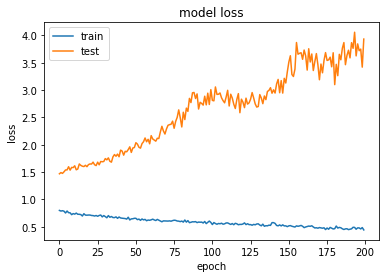

In [267]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# input:
l_in_pep = tf.placeholder(tf.float32, shape=[None,None,n_features])
l_in_tcr = tf.placeholder(tf.float32, shape=[None,None,n_features])
drop_rate = tf.placeholder(tf.float32, shape=())

# convolutional layers on peptide:
l_conv_pep_1 = tf.layers.conv1d(inputs=l_in_pep, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_pep_3 = tf.layers.conv1d(inputs=l_in_pep, filters=n_filters, kernel_size=3, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_pep_5 = tf.layers.conv1d(inputs=l_in_pep, filters=n_filters, kernel_size=5, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_pep_7 = tf.layers.conv1d(inputs=l_in_pep, filters=n_filters, kernel_size=7, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_pep_9 = tf.layers.conv1d(inputs=l_in_pep, filters=n_filters, kernel_size=9, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)

# convolutional layers on TCR:
l_conv_tcr_1 = tf.layers.conv1d(inputs=l_in_tcr, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_tcr_3 = tf.layers.conv1d(inputs=l_in_tcr, filters=n_filters, kernel_size=3, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_tcr_5 = tf.layers.conv1d(inputs=l_in_tcr, filters=n_filters, kernel_size=5, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_tcr_7 = tf.layers.conv1d(inputs=l_in_tcr, filters=n_filters, kernel_size=7, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_tcr_9 = tf.layers.conv1d(inputs=l_in_tcr, filters=n_filters, kernel_size=9, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)

# second convolutional layer:
l_conc_1 = tf.concat([l_conv_pep_1, l_conv_tcr_1], axis=1)
l_conc_3 = tf.concat([l_conv_pep_3, l_conv_tcr_3], axis=1)
l_conc_5 = tf.concat([l_conv_pep_5, l_conv_tcr_5], axis=1)
l_conc_7 = tf.concat([l_conv_pep_7, l_conv_tcr_7], axis=1)
l_conc_9 = tf.concat([l_conv_pep_9, l_conv_tcr_9], axis=1)

l_conv_2_1 = tf.layers.conv1d(inputs=l_conc_1, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_2_3 = tf.layers.conv1d(inputs=l_conc_3, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_2_5 = tf.layers.conv1d(inputs=l_conc_5, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_2_7 = tf.layers.conv1d(inputs=l_conc_7, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)
l_conv_2_9 = tf.layers.conv1d(inputs=l_conc_9, filters=n_filters, kernel_size=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding="same", activation=tf.nn.sigmoid)

# max pooling:
l_pool_max_1 = tf.reduce_max(l_conv_2_1,axis=1)
l_pool_max_3 = tf.reduce_max(l_conv_2_3,axis=1)
l_pool_max_5 = tf.reduce_max(l_conv_2_5,axis=1)
l_pool_max_7 = tf.reduce_max(l_conv_2_7,axis=1)
l_pool_max_9 = tf.reduce_max(l_conv_2_9,axis=1)

# concatenate:
l_conc = tf.concat([l_pool_max_1, l_pool_max_3, l_pool_max_5, l_pool_max_7, l_pool_max_9], axis=1)

# dense hidden layer:
l_dense = tf.layers.dense(inputs=l_conc, units=n_hid, activation=tf.nn.sigmoid)

# dropout:
l_dense_drop = tf.layers.dropout(inputs=l_dense, rate=drop_rate, noise_shape=None, seed=None, training=True)

# output layer:
out = tf.layers.dense(inputs=l_dense_drop, units=1, activation=tf.nn.sigmoid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
# Sources
www.tensorflow.org/tutorials
https://dmnfarrell.github.io/bioinformatics/mhclearning
https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py